<a href="https://colab.research.google.com/github/Hamza098-code/animated-octo-fishstick/blob/main/%20Stress_Hydrique_au_Maroc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 Projet : Prédiction du Stress Hydrique au Maroc (AI & Data Science)
**Auteur :** LBOUKHARI Hamza  
**Master :** Mathématiques et Ingénierie Numérique  
**Sujet :** Modélisation et prévision des ressources en eau (Taux de remplissage des barrages) en utilisant le Machine Learning.

---
### 🎯 Objectif du Notebook
Ce projet vise à développer un modèle prédictif capable d'estimer le niveau des barrages (ou le stress hydrique) en fonction des données climatiques historiques (Pluviométrie, Température).

**Sources de données :**
1. **Climat :** Open-Meteo API (Données satellites en temps réel).
2. **Hydrologie :** Données simulées (à remplacer par les données réelles de l'ABH).

In [7]:
# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configuration du style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliothèques importées avec succès.")

✅ Bibliothèques importées avec succès.


In [8]:
# 2. Collecte des Données Climatiques
import requests
import pandas as pd

def get_open_meteo_data(lat, lon, start_year, end_year):

    url = "https://archive-api.open-meteo.com/v1/archive"

    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_mean,precipitation_sum",
        "timezone": "auto"
    }

    print(f"⏳Connexion en cours aux serveurs Open-Meteo pour la région ({lat}, {lon})...")

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        daily_data = data['daily']

        df = pd.DataFrame({
            'Temperature_C': daily_data['temperature_2m_mean'],
            'Pluie_mm': daily_data['precipitation_sum']
        })

        df.index = pd.to_datetime(daily_data['time'])

        print("✅  Les données ont été téléchargées avec succès depuis Open-Meteo !")
        return df

    except Exception as e:
        print(f"❌ Une erreur s'est produite lors de la récupération des données :  {e}")
        return None


df_climate = get_open_meteo_data(32.477, -7.489, 2015, 2023)

if df_climate is not None:
    print(df_climate.head())

⏳Connexion en cours aux serveurs Open-Meteo pour la région (32.477, -7.489)...
✅  Les données ont été téléchargées avec succès depuis Open-Meteo !
            Temperature_C  Pluie_mm
2015-01-01            9.8       0.0
2015-01-02           10.8       0.0
2015-01-03           10.9       0.0
2015-01-04           10.9       0.0
2015-01-05           10.7       0.0


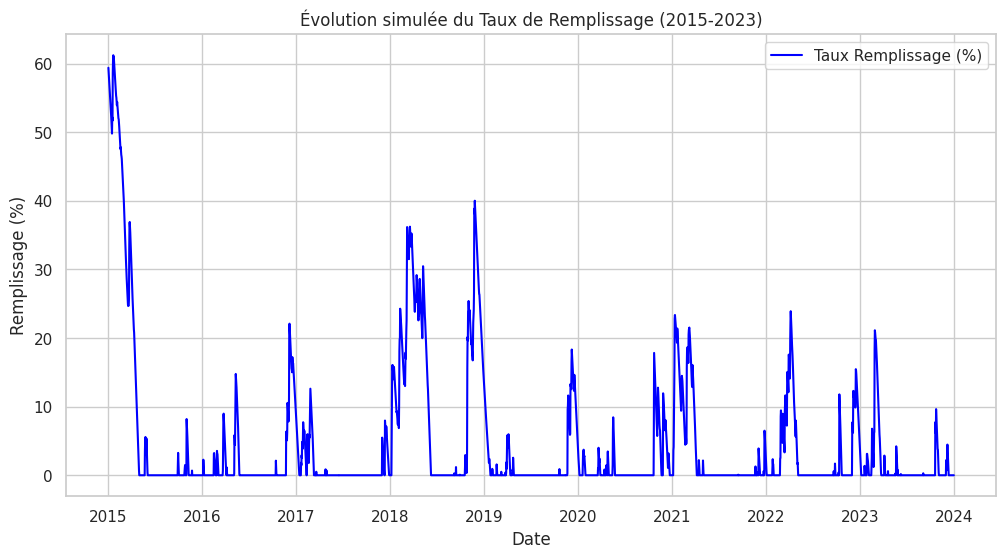

In [9]:
# 3. Simulation de la Cible (Target Variable)
# NOTE : Cette étape est temporaire en attendant les données réelles (ABH).
# Nous simulons un taux de remplissage basé sur une équation hydrologique simplifiée.

def simulate_dam_level(df):
    levels = []
    current_level = 60 # Niveau initial (%)

    for i in range(len(df)):
        rain = df.iloc[i]['Pluie_mm']
        temp = df.iloc[i]['Temperature_C']

        # Logique simplifiée : La pluie augmente le niveau, la chaleur l'évapore
        apport = rain * 0.5
        evaporation = (temp * 0.05) + 0.1 # Consommation quotidienne

        current_level += apport - evaporation

        # Contraintes physiques (0% min, 100% max)
        current_level = max(0, min(100, current_level))
        levels.append(current_level)

    return levels

df_climate['Taux_Remplissage'] = simulate_dam_level(df_climate)

# Visualisation des données
plt.plot(df_climate.index, df_climate['Taux_Remplissage'], label='Taux Remplissage (%)', color='blue')
plt.title("Évolution simulée du Taux de Remplissage (2015-2023)")
plt.xlabel("Date")
plt.ylabel("Remplissage (%)")
plt.legend()
plt.show()

In [10]:
# 4. Feature Engineering (Préparation des données)
# L'eau de pluie met du temps à arriver au barrage. Nous créons des variables "décalées" (Lags).

df_model = df_climate.copy()

# Moyenne mobile des 7 derniers jours (Pluie cumulée)
df_model['Pluie_Rolling_7d'] = df_model['Pluie_mm'].rolling(window=7).sum()

# Moyenne mobile des 30 derniers jours
df_model['Pluie_Rolling_30d'] = df_model['Pluie_mm'].rolling(window=30).sum()

# Température moyenne 7 jours
df_model['Temp_Rolling_7d'] = df_model['Temperature_C'].rolling(window=7).mean()

# Lag 1 (Le niveau d'hier influence le niveau d'aujourd'hui)
df_model['Prev_Level'] = df_model['Taux_Remplissage'].shift(1)

# Suppression des valeurs nulles (NaN) créées par le décalage
df_model.dropna(inplace=True)

df_model.head()

,Temperature_C,Pluie_mm,Taux_Remplissage,Pluie_Rolling_7d,Pluie_Rolling_30d,Temp_Rolling_7d,Prev_Level
2015-01-30,11.3,0.0,55.905,0.0,30.3,10.528571,56.570
2015-01-31,12.7,0.3,55.320,0.3,30.6,10.857143,55.905
2015-02-01,11.4,0.8,55.050,1.1,31.4,11.014286,55.320
2015-02-02,8.7,0.0,54.515,1.1,31.4,10.742857,55.050
2015-02-03,9.4,0.0,53.945,1.1,31.4,10.514286,54.515


In [11]:
# 5. Modélisation (Machine Learning)

# Définition des variables X (Features) et Y (Target)
features = ['Pluie_mm', 'Temperature_C', 'Pluie_Rolling_7d', 'Pluie_Rolling_30d', 'Temp_Rolling_7d', 'Prev_Level']
X = df_model[features]
y = df_model['Taux_Remplissage']

# Division Train/Test (On ne mélange pas les données temporelles !)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Données d'entraînement : {X_train.shape}")
print(f"Données de test : {X_test.shape}")

# Initialisation et Entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("✅ Modèle entraîné avec succès.")

Données d'entraînement : (2606, 6)
Données de test : (652, 6)
✅ Modèle entraîné avec succès.


📊 Performance du modèle :
RMSE (Erreur Moyenne) : 0.30 %
R² (Précision) : 1.00


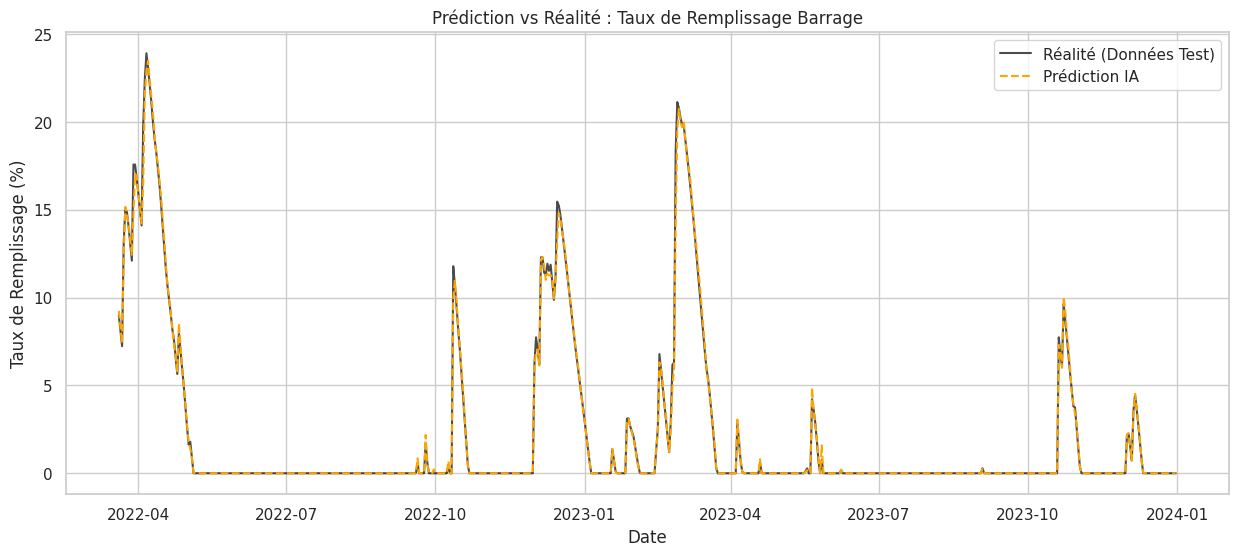

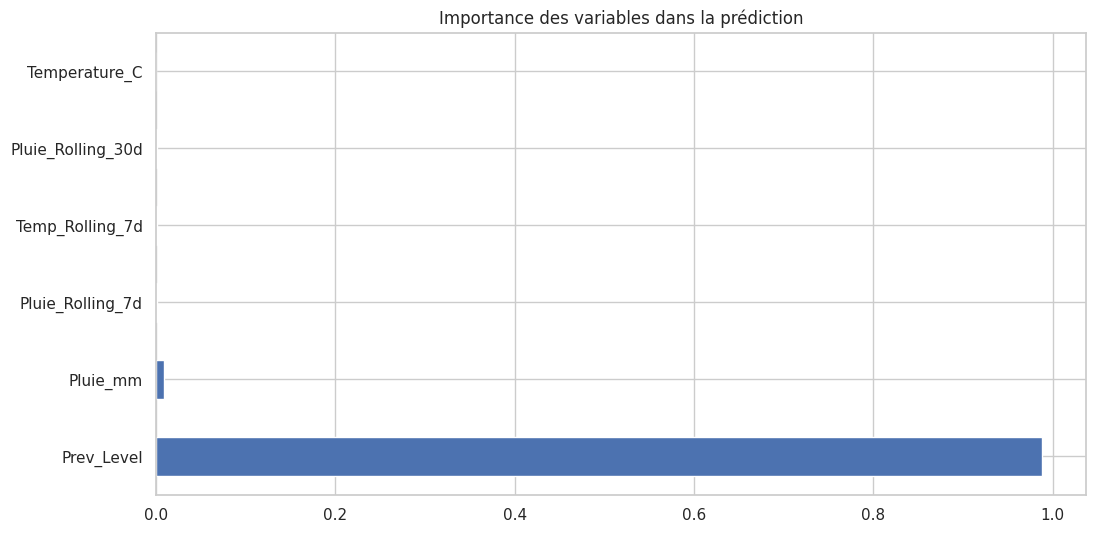

In [12]:
# 6. Évaluation et Visualisation des résultats

# Prédiction
predictions = model.predict(X_test)

# Calcul des erreurs
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"📊 Performance du modèle :")
print(f"RMSE (Erreur Moyenne) : {rmse:.2f} %")
print(f"R² (Précision) : {r2:.2f}")

# Comparaison Graphique (Réalité vs Prédiction)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Réalité (Données Test)', color='black', alpha=0.7)
plt.plot(y_test.index, predictions, label='Prédiction IA', color='orange', linestyle='--')

plt.title("Prédiction vs Réalité : Taux de Remplissage Barrage")
plt.xlabel("Date")
plt.ylabel("Taux de Remplissage (%)")
plt.legend()
plt.show()

# Importance des variables
importances = pd.Series(model.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh', title="Importance des variables dans la prédiction")
plt.show()